In [1]:
import os
import warnings
import datetime
warnings.filterwarnings("ignore") # remove some scikit-image warnings

from torch.utils.tensorboard import SummaryWriter

import monai
# monai.config.print_config()

from monai.apps import DecathlonDataset
from monai.data import DataLoader, CacheDataset, decollate_batch
from monai.utils import first, set_determinism
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss, DiceCELoss
from monai.inferers import sliding_window_inference
from monai.networks.nets import UNETR
from monai.transforms import (
    LoadImage,
    LoadImageD,
    EnsureChannelFirstD,
#     AddChannelD,
    ScaleIntensityD,
    ToTensorD,
    Compose,
    AsDiscreteD,
    SpacingD,
    OrientationD,
    ResizeD,
    RandAffineD,
    AsDiscrete,
    AsDiscreted,
    EnsureTyped,
    EnsureType,
    LoadImageD,
    EnsureChannelFirstD,
    OrientationD,
    SpacingD,
    ScaleIntensityD,
    ResizeD,
    RandAffineD,
    RandFlipD,
    RandRotateD,
    RandZoomD,
    ToTensorD,
)

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv



from monai.utils.misc import set_determinism

set_determinism(seed = 42)

In [2]:
device = torch.device("cpu")
UNETR_metadata = dict(
    in_channels=1,
    out_channels=2,
    img_size=(128, 128, 64), 
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    pos_embed='conv',
    norm_name='instance',
    conv_block=True,
    res_block=True,
    dropout_rate=0.0,
    spatial_dims=3,
)

model = UNETR(**UNETR_metadata).to(device)

In [3]:
def get_validation_indexes():
    list_val_dataset = []
    csv_file = 'val_dataset_NEW_64slices.csv'

    with open(csv_file, 'r', newline='', encoding='utf-8') as file:
        # Create a CSV reader object
        reader = csv.reader((line.replace('\0', '') for line in file))
        
        # Iterate over each row in the CSV file
        for row in reader:
            # Append the row to the list
            list_val_dataset.append(row)
            
    list_val_dataset = [[int(num) for num in row] for row in list_val_dataset]
    return list_val_dataset

KEYS = ["image", "label"]
val_transform = Compose([
    LoadImageD(keys = KEYS),
    EnsureChannelFirstD(keys = KEYS),
    OrientationD(KEYS, axcodes='RAS'),
    ScaleIntensityD(keys = "image"),
])

# Load validation data
val_dataset = DecathlonDataset(root_dir = "C:/Users/diana/Desktop/Licenta+Prelucrare MSD",
                           task = "Task06_Lung", section = "validation",
                           transform = val_transform, download = False)
list_val_dataset = get_validation_indexes()
for idx in range(len(val_dataset)):
    # Access individual elements by index
    sample = val_dataset[idx]
    
    image = sample["image"]
    label = sample["label"]
    
    
    image_slices = list_val_dataset[idx]

    image = image[..., image_slices]
    label = label[..., image_slices]
    
    sample["image"] = image
    sample["label"] = label

# Apply the remaining tranforms
KEYS = ["image", "label"]
remaining_val_transform = Compose([
    SpacingD(keys = KEYS,
             pixdim = (1., 1., 1.),
             mode = ('bilinear', 'nearest')),
    ResizeD(KEYS,
            (128, 128, 64),
            mode=('trilinear', 'nearest')),
    ToTensorD(KEYS),
])


for idx in range(len(val_dataset)):
    # Access individual elements by index
    sample = val_dataset[idx]
    transformed_sample = remaining_val_transform(sample)
    
    sample["image"] = transformed_sample["image"]
    sample["label"] = transformed_sample["label"]
    
    image = sample["image"]
    label = sample["label"]


val_loader = DataLoader(val_dataset, batch_size = 1, shuffle = True, num_workers = 4)
checker = first(val_loader)
image, label = checker['image'], checker['label']



Loading dataset: 100%|██████████| 12/12 [01:03<00:00,  5.26s/it]


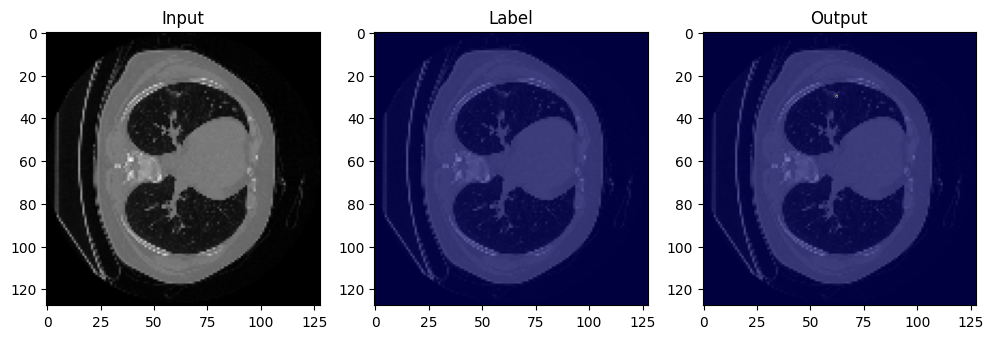

In [4]:
# Load the model state dict while ignoring missing or unexpected keys

best_models = ["best_pretrained_models_dice\lr_0.001_epoch_300_model_Adam_day_2024-06-22_14-48-29.pth",
               "best_pretrained_models_dice\lr_0.001_epoch_200_model_Adam_day_2024-06-06_21-48-59_combo_2611.pth",
               "best_pretrained_models_dice\lr_0.001_epoch_200_model_Nadam_day_2024-06-07_14-02-24_combo_2617.pth",
               "best_pretrained_models_dice\lr_0.0001_epoch_200_model_Nadam_day_2024-06-09_11-36-20_combo_2634.pth"]
state_dict = torch.load(best_models[0], map_location=torch.device('cpu'))
model.load_state_dict(state_dict, strict=False)

with torch.no_grad():
  output = model(image)
  output = torch.nn.Softmax()(output)
  output = torch.round(output)

  slide = 28
  plt.figure("Test Model", (12, 12))

  plt.subplot(1, 3, 1)
  plt.title("Input")
  plt.imshow(image[0, 0, :, :, slide], cmap = "gray")

  plt.subplot(1, 3, 2)
  plt.title("Label")
  plt.imshow(image[0, 0, :, :, slide], cmap = "gray")
  plt.imshow(label[0, 0, :, :, slide], cmap = 'jet', alpha = 0.5)

  plt.subplot(1, 3, 3)
  plt.title("Output")
  plt.imshow(image[0, 0, :, :, slide], cmap = "gray")
  plt.imshow(output[0, 1, :, :, slide], cmap = 'jet', alpha = 0.5)

  plt.show()

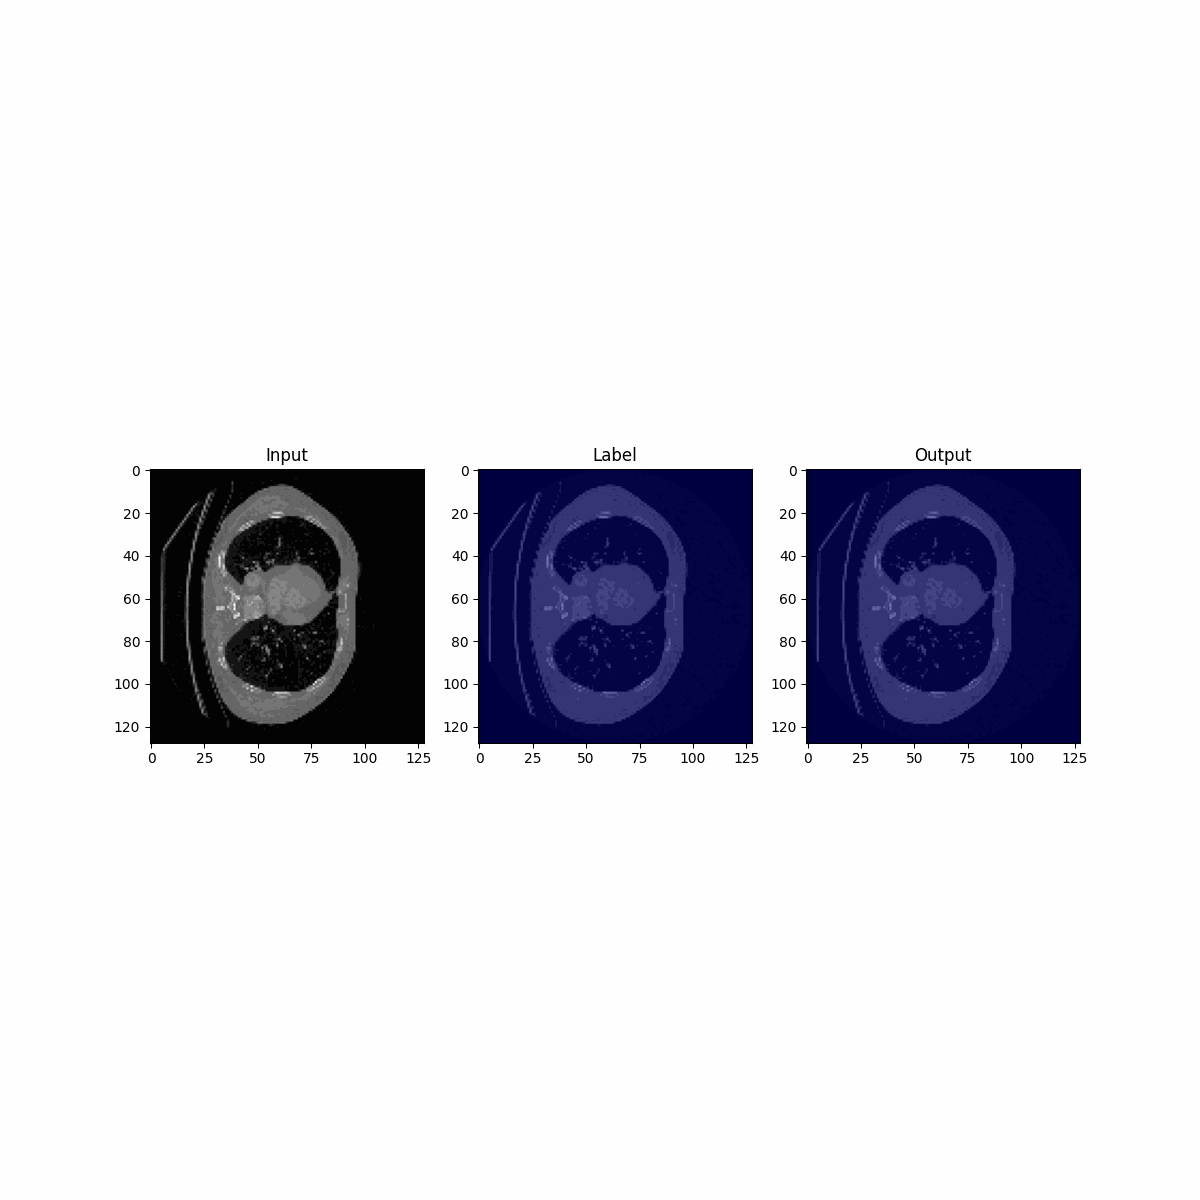

In [5]:
import os
import torch
import matplotlib.pyplot as plt
import imageio
from IPython.display import Image

def predict(image, label, model, slide, folder):
    with torch.no_grad():
        output = model(image)
        output = torch.nn.Softmax(dim=1)(output)
        output = torch.round(output)

        plt.figure("Test Model", (12, 12))

        plt.subplot(1, 3, 1)
        plt.title("Input")
        plt.imshow(image[0, 0, :, :, slide], cmap="gray")

        plt.subplot(1, 3, 2)
        plt.title("Label")
        plt.imshow(image[0, 0, :, :, slide], cmap="gray")
        plt.imshow(label[0, 0, :, :, slide], cmap='jet', alpha=0.5)

        plt.subplot(1, 3, 3)
        plt.title("Output")
        plt.imshow(image[0, 0, :, :, slide], cmap="gray")
        plt.imshow(output[0, 1, :, :, slide], cmap='jet', alpha=0.5)

        # Salvează imaginea în folderul specificat
        frame_path = os.path.join(folder, f"frame_{slide}.png")
        plt.savefig(frame_path)
        plt.close()

# Definește indexul pacientului
patient_index = 12

# Verifică că indexul pacientului este valid
num_patients = len(val_loader)
if not (1 <= patient_index <= num_patients):
    raise ValueError(f"patient_index trebuie să fie în intervalul 1-{num_patients}")

# Creează un folder pentru frame-uri dacă nu există
folder = f"frames_patient_{patient_index}"
os.makedirs(folder, exist_ok=True)

val_loader_iter = iter(val_loader)
for i in range(patient_index):
    data = next(val_loader_iter)
image, label = data['image'], data['label']

# Parcurge toate cele 64 de slide-uri și salvează frame-urile
frames = []
for slide in range(64):
    predict(image, label, model, slide, folder)
    frames.append(imageio.imread(os.path.join(folder, f"frame_{slide}.png")))

# Creează GIF-ul
gif_path = f'patient_{patient_index}.gif'
imageio.mimsave(gif_path, frames, duration=0.5)

# Afișează GIF-ul
Image(filename=gif_path)
